In [51]:
!pip install tqdm
!pip install seaborn
!pip install opencv-python


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [52]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from tqdm.notebook import tqdm
from time import time

import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp

In [53]:
class cfg:
    data_dir = "data/train"
    img_dir = f"{data_dir}/images" # 
    # 000001_female_Asian_45
    df_path = f"{data_dir}/train.csv"

    data_dir_eval = "data/eval"
    img_dir_eval = f"{data_dir_eval}/images" # 
    # 000001_female_Asian_45
    df_path_eval = f"{data_dir_eval}/info.csv"
    

In [54]:
inp_train= pd.read_csv(cfg.df_path)
inp_train.head()
inp_eval= pd.read_csv(cfg.df_path_eval)
inp_eval.head()

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,0
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,0
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,0
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,0
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,0


# Labeling
## 목적: 우리가 원하는 값만을 담은 새로운 csv파일 생성
- 0 ~ 17 클래스 반영
- EDA를 위해서 gender, age, wear 값 반영


In [105]:
def MakeDataFrame(inp, image_dir):
    file_path = []
    # image_dir "data/train/images"
    # 006959_male_Asian_19 -> df.path
    
    df = pd.DataFrame(columns=['persion_id', 'image_path', 'gender', 'age', 'wear', 'f_class'])
    
    i = 0
    for sub_dir in inp.path:
        # print(img_path)
        persion_id, gender, race, age = sub_dir.split("_")
        for file_name in os.listdir(os.path.join(image_dir, sub_dir)):
            # print(file_name.split("."))
            wear, ext = file_name.split(".")
            
            gender_class = 0 if gender=='male' else  1
            
            age_class = int(age)//30
            
            if wear =='normal':
                wear_class = 2
            elif wear == 'incorrect_mask':
                wear_class = 1
            else:
                wear_class = 0
            
            final_class = 6 * wear_class + 3 * gender_class + age_class
            file_path.append(final_class)
            image_path = os.path.join(image_dir, sub_dir, file_name)
            df.loc[i] = [persion_id, image_path, gender_class, age_class, wear_class, final_class]
            i += 1
            
    return df

dataset_train = MakeDataFrame(inp_train, cfg.img_dir)
# dataset_train.head()
dataset_train.to_csv("dataset_train.csv") # 새로운 csv파일 생성

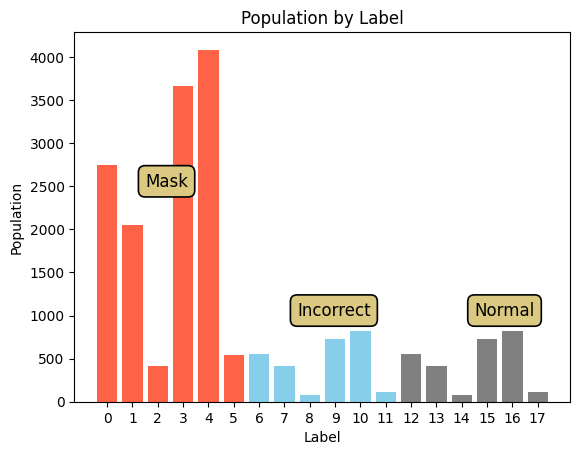

In [182]:
dataset_train.f_class.value_counts()
label_data = dataset_train.groupby('f_class').count()['gender']
# Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], dtype='int64', name='f_class')
# label_data.index 

plt.bar(label_data.index, label_data, color='tomato')
plt.bar(label_data[6:12].index, label_data[6:12], color='skyblue')
plt.bar(label_data[12:].index, label_data[12:], color='gray')
plt.xticks(label_data.index)

plt.annotate('Mask', xy=(1.5, 2500), fontsize=12, bbox=dict(boxstyle='round', pad=0.4, facecolor='#dbc981', linewidth=1.2))
plt.annotate('Incorrect', xy=(7.5, 1000), fontsize=12, bbox=dict(boxstyle='round', pad=0.4, facecolor='#dbc981', linewidth=1.2))
plt.annotate('Normal', xy=(14.5, 1000), fontsize=12, bbox=dict(boxstyle='round', pad=0.4, facecolor='#dbc981', linewidth=1.2))

plt.xlabel('Label')
plt.ylabel('Population')
plt.title('Population by Label')
plt.show()


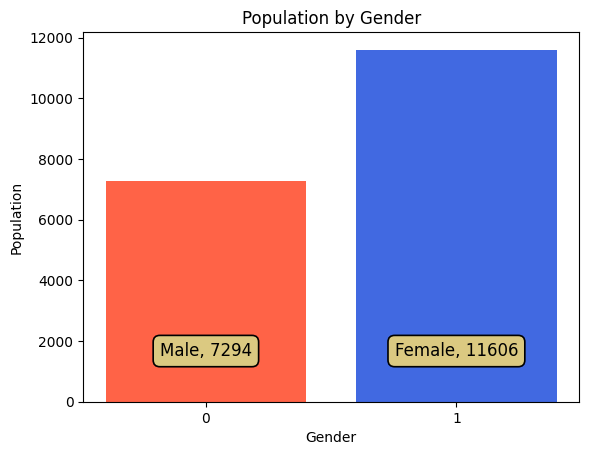

In [194]:
import matplotlib.pyplot as plt

dataset_train.gender.value_counts()
gender_data = dataset_train.groupby('gender').count()["f_class"]

plt.bar(0, gender_data[0], color='tomato')
plt.bar(1, gender_data[1], color='royalblue')
plt.xticks(gender_data.index)

plt.annotate(f'Male, {gender_data[0]}', xy=(0, 0), xytext=(0, 30), textcoords='offset points', fontsize=12, bbox=dict(boxstyle='round', pad=0.4, facecolor='#dbc981', linewidth=1.2), ha='center', va='bottom')
plt.annotate(f'Female, {gender_data[1]}', xy=(1, 0), xytext=(0, 30), textcoords='offset points', fontsize=12, bbox=dict(boxstyle='round', pad=0.4, facecolor='#dbc981', linewidth=1.2), ha='center', va='bottom')

plt.xlabel('Gender')
plt.ylabel('Population')
plt.title('Population by Gender')
plt.show()

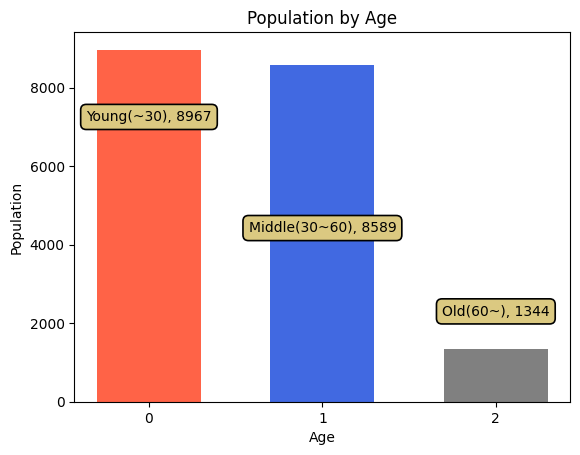

In [216]:
age_data = dataset_train.groupby('age').count()["f_class"]

plt.bar(0, age_data[0], color='tomato', width=0.6)
plt.bar(1, age_data[1], color='royalblue', width=0.6)
plt.bar(2, age_data[2], color='gray', width=0.6)
plt.xticks(age_data.index)

plt.annotate(f'Young(~30), {age_data[0]}', xy=(0, 0), xytext=(0, 200), textcoords='offset points', fontsize=10, bbox=dict(boxstyle='round', pad=0.4, facecolor='#dbc981', linewidth=1.2), ha='center', va='bottom')
plt.annotate(f'Middle(30~60), {age_data[1]}', xy=(1, 0), xytext=(0, 120), textcoords='offset points', fontsize=10, bbox=dict(boxstyle='round', pad=0.4, facecolor='#dbc981', linewidth=1.2), ha='center', va='bottom')
plt.annotate(f'Old(60~), {age_data[2]}', xy=(2, 0), xytext=(0, 60), textcoords='offset points', fontsize=10, bbox=dict(boxstyle='round', pad=0.4, facecolor='#dbc981', linewidth=1.2), ha='center', va='bottom')


plt.xlabel('Age')
plt.ylabel('Population')
plt.title('Population by Age')
plt.show()

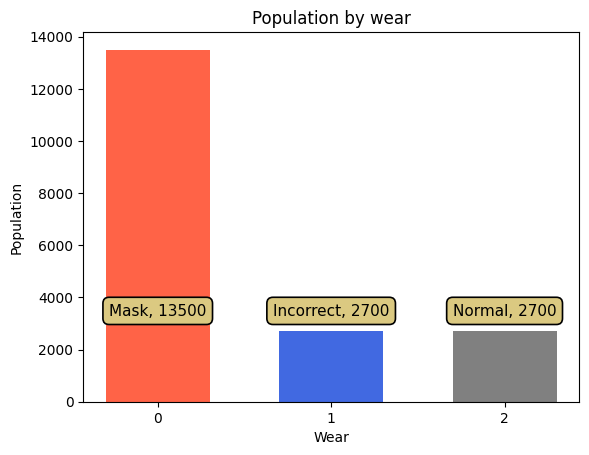

In [219]:
wear_data = dataset_train.groupby('wear').count()["f_class"]

plt.bar(0, wear_data[0], color='tomato', width=0.6)
plt.bar(1, wear_data[1], color='royalblue', width=0.6)
plt.bar(2, wear_data[2], color='gray', width=0.6)
plt.xticks(wear_data.index)

plt.annotate(f'Mask, {wear_data[0]}', xy=(0, 0), xytext=(0, 60), textcoords='offset points', fontsize=11, bbox=dict(boxstyle='round', pad=0.4, facecolor='#dbc981', linewidth=1.2), ha='center', va='bottom')
plt.annotate(f'Incorrect, {wear_data[1]}', xy=(1, 0), xytext=(0, 60), textcoords='offset points', fontsize=11, bbox=dict(boxstyle='round', pad=0.4, facecolor='#dbc981', linewidth=1.2), ha='center', va='bottom')
plt.annotate(f'Normal, {wear_data[2]}', xy=(2, 0), xytext=(0, 60), textcoords='offset points', fontsize=11, bbox=dict(boxstyle='round', pad=0.4, facecolor='#dbc981', linewidth=1.2), ha='center', va='bottom')


plt.xlabel('Wear')
plt.ylabel('Population')
plt.title('Population by wear')
plt.show()